## 1. Introduction
<p><a href="https://commons.wikimedia.org/wiki/File:Tux.svg">
<img style="float: right;margin:5px 20px 5px 1px" width="150px" src="https://assets.datacamp.com/production/project_111/img/tux.png" alt="Tux: la mascota de Linux">
</a></p>
<p>Los repositorios de control de versiones como CVS, Subversion o Git pueden ser una verdadera mina de oro para los desarrolladores de software. Contienen cada cambio realizado al código fuente, incluyendo la fecha (el "cuándo"), el desarrollador responsable (el "quién"), así como un pequeño mensaje que describe la intención (el "qué") de un cambio.</p>
<p>En este cuaderno, analizaremos la evolución de un proyecto de código abierto muy famoso: el kernel de Linux. El kernel de Linux es el corazón de algunas distribuciones de Linux como Debian, Ubuntu o CentOS. Nuestro conjunto de datos contiene el historial del desarrollo del kernel durante casi 13 años (principios de 2005 - finales de 2017). Obtendremos información sobre el trabajo de los esfuerzos de desarrollo mediante:</p>
<ul>
<li>Identificar a los 10 principales contribuyentes </li>
<li>Visualizar los commits a lo largo de los años.</li>
</ul>

In [1]:
# Importamos las Librerías
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# Leemos el CSV
# sep para indicar el separador, header para establecer las columnas y names para establecer los nomvres de las columnas
df = pd.read_csv("datasets/git_log_excerpt.csv", sep="#", header=None, names=["timestamp", "author"])

# Visualizamos los 10 primeros elementos
display(df.head(10))

,timestamp,author
0,1502382966,Linus Torvalds
1,1501368308,Max Gurtovoy
2,1501625560,James Smart
3,1501625559,James Smart
4,1500568442,Martin Wilck
5,1502273719,Xin Long
6,1502278684,Nikolay Borisov
7,1502238384,Girish Moodalbail
8,1502228709,Florian Fainelli
9,1502223836,Jon Paul Maloy


## 2. Reading in the dataset
<p>El conjunto de datos fue creado utilizando el comando <code>git log --encoding=latin-1 --pretty="%at#%aN"</code> a finales de 2017. La salida de texto codificada en <code>latin-1</code> se guardó en un archivo CSV sin encabezado. En este archivo, cada fila es una entrada de commit con la siguiente información:</p>
<ul>
<li><code>timestamp</code>: la hora del commit como una marca de tiempo UNIX en segundos desde 1970-01-01 00:00:00 (Marcador de posición de Git log "<code>%at</code>")</li>
<li><code>author</code>: el nombre del autor que realizó el commit (Marcador de posición de Git log "<code>%aN</code>")</li>
</ul>
<p>Las columnas están separadas por el signo de número <code>#</code>. El conjunto de datos completo se encuentra en el directorio <code>datasets/</code>. Es un archivo csv comprimido en <code>gz</code> llamado <code>git_log.gz</code>.</p>

In [2]:
# Leemos el archivo correcto
git_log = pd.read_csv("datasets/git_log_data.csv")

# Mostramos los 5 primeros elementos
git_log.head()

,timestamp,author
0,1502826583,Linus Torvalds
1,1501749089,Adrian Hunter
2,1501749088,Adrian Hunter
3,1501882480,Kees Cook
4,1497271395,Rob Clark


## 3. Obteniendo una visión general
<p>El conjunto de datos contiene información sobre cada contribución de código (un "commit") al kernel de Linux en los últimos 13 años. Primero echaremos un vistazo al número de autores y sus commits en el repositorio.</p>

In [3]:
# Calculamos el número de commits
number_of_commits = len(git_log)

# Calculamos el número de autores
number_of_authors = git_log["author"].nunique()

# Imprimimos el número de autores que hicieron commits
print("%s authors committed %s code changes." % (number_of_authors, number_of_commits))

17385 authors committed 699071 code changes.


## 4. Encontrando los 10 principales contribuyentes
<p>Existen algunas personas muy importantes que han realizado cambios frecuentes en el kernel de Linux. Para ver si hay algún cuello de botella, vamos a analizar a los 10 principales autores con más commits.</p>

In [4]:
# Identificamos los 10 primero autores que hicieron más commits
top_10_authors = git_log["author"].value_counts().head(10)

# Listing contents of 'top_10_authors'
top_10_authors

author
Linus Torvalds           23361
David S. Miller           9106
Mark Brown                6802
Takashi Iwai              6209
Al Viro                   6006
H Hartley Sweeten         5938
Ingo Molnar               5344
Mauro Carvalho Chehab     5204
Arnd Bergmann             4890
Greg Kroah-Hartman        4580
Name: count, dtype: int64

## 5. Manipulando los datos
<p>Para nuestro análisis, queremos visualizar las contribuciones a lo largo del tiempo. Para esto, utilizaremos la información en la columna <code>timestamp</code> para crear una columna basada en series de tiempo.</p>

In [5]:
# Corregimos la columnas timestamp que esta en segundos para pasarlo a un formato fecha
git_log["timestamp"] = pd.to_datetime(git_log["timestamp"], unit="s")

# Visualizamos 
git_log

,timestamp,author
0,2017-08-15 19:49:43,Linus Torvalds
1,2017-08-03 08:31:29,Adrian Hunter
2,2017-08-03 08:31:28,Adrian Hunter
3,2017-08-04 21:34:40,Kees Cook
4,2017-06-12 12:43:15,Rob Clark
...,...,...
699066,2005-04-16 22:23:56,akpm@osdl.org
699067,2005-04-16 22:23:55,akpm@osdl.org
699068,2005-04-16 22:23:54,Neil Brown
699069,2005-04-16 22:23:53,Christoph Lameter


## 6. Tratando los timestamps incorrectos
<p>Como podemos ver en los resultados anteriores, algunos contribuyentes tenían incorrectamente configurada la hora de su sistema operativo cuando realizaron los commits en el repositorio. Vamos a limpiar la columna <code>timestamp</code> eliminando las filas con timestamps incorrectos.</p>

In [6]:
# Obtenemos Primer Día del 2005
principio_2005 = pd.to_datetime("2005")

#Filtramos que nuestros commits sean de ese año hacia delante.
git_log_filtrado = git_log[git_log["timestamp"] >= principio_2005]

# Hallamos el primer commit que se hizo en el 2005
first_commit_timestamp = git_log_filtrado["timestamp"].min()

# Hallamos el ultimo commit que se hizo en el 2018
last_commit_timestamp = pd.to_datetime("2018")

# Establecemos lso commits válidos que son del 2005 hasta el 2017
corrected_log = git_log[(git_log["timestamp"] >= first_commit_timestamp) & (git_log_filtrado["timestamp"]<= last_commit_timestamp)]

## 7. Agrupando los commits por año
<p>Para determinar cómo ha aumentado la actividad de desarrollo a lo largo del tiempo, vamos a agrupar los commits por año y contarlos.</p>

In [7]:
# Rellenamos el valor nulo del autor por un valor desconocido
corrected_log["author"] = corrected_log["author"].fillna("Unknown")

# Creamos una columna que guardará el año de la fecha que tenemos
corrected_log["Year"] = corrected_log["timestamp"].dt.year

# Agrupamos por año y realizamos un conteo
commit_per_year = corrected_log.groupby(["Year"]).count().reset_index()

## 8. Visualizando la historia de Linux
<p>Finalmente, crearemos un gráfico a partir de estos recuentos para poder visualizar mejor cómo ha aumentado el esfuerzo de desarrollo en Linux en los últimos años.</p>

<Axes: xlabel='Year', ylabel='timestamp'>

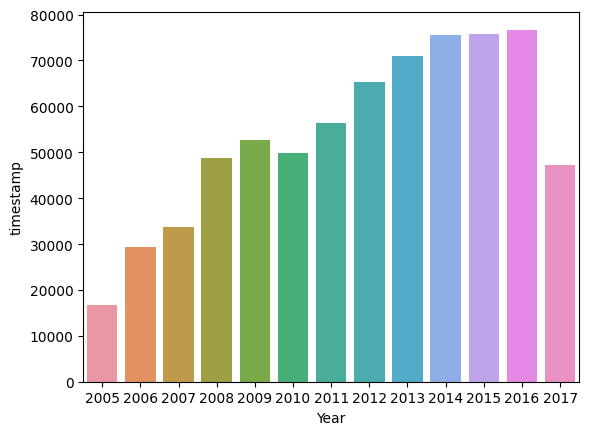

In [8]:
sns.barplot(data=commit_per_year, x="Year", y="timestamp")

## 9. Conclusión
<p>Gracias a la sólida base y al cuidado de Linux Torvalds, muchos otros desarrolladores ahora también pueden contribuir al kernel de Linux. ¡No se observa una disminución de la actividad de desarrollo a la vista!</p>

In [9]:
# calculating or setting the year with the most commits to Linux
year_with_most_commits = 2016 